In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow import keras
import sys
import PIL
import os
import tensorflow.keras.backend as K
import glob
sys.path.append('../scripts/helper_functions_cv/tensorflow_helpers/')
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
import segmentation_models as sm
sm.set_framework('tf.keras')
import multiprocessing as mp
from save_weights_every_epoch import CallbackForSavingModelWeights
from change_learning_rate_epoch import ChangeLR
import multiprocessing as mp

Segmentation Models: using `keras` framework.


In [2]:
csv_file = pd.read_csv('../../files/train_ship_segmentations_v2.csv')
csv_file = csv_file.groupby('ImageId')['EncodedPixels'].apply(list).reset_index()
image_ids, pixels = csv_file['ImageId'].values.tolist(), csv_file['EncodedPixels'].values.tolist()

In [3]:
csv_file['fixed_inputs'] = csv_file['ImageId'].apply(lambda x: '../../files/train_v2/' + x)
csv_file['mask_paths'] = csv_file['ImageId'].apply(lambda x: '../../files/masks_v1/train/' + x.split('.')[0] + '.' + 'png')

In [4]:
for x in csv_file['fixed_inputs'].values.tolist():
    if os.path.exists(x) == False:
        print(x)

In [5]:
for x in csv_file['mask_paths'].values.tolist():
    if os.path.exists(x) == False:
        print(x)

In [6]:
csv_file = csv_file[csv_file['fixed_inputs'] != '/home/ubuntu/ml-data-training/ship_segmentation_data/train_v2/6384c3e78.jpg']

In [7]:
# def read_img(path):
#     try:
#         im = tf.io.read_file(path)
#         im = tf.image.decode_jpeg(im, channels = 3)
#         return 'DONE'
#     except:
#         return path

In [8]:
# temp = []
# for x in tqdm(csv_file['fixed_inputs'].values.tolist()):
#     temp.append(read_img(x))

Input and masks path checks are done.

In [9]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]

In [10]:
allowed_gpus = [0, 1, 2, 3, 4, 5, 6, 7]
gpus = tf.config.list_physical_devices("GPU")
final_gpu_list = [gpus[x] for x in allowed_gpus]
tf.config.set_visible_devices(final_gpu_list, "GPU")

strategy = tf.distribute.MirroredStrategy()
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


In [11]:
print(REPLICAS)

8


In [12]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]

In [13]:
load_dotenv('../config_files/dev.env')

True

In [14]:
def split_datasets(csv_file, test_size = 0.01):
    train, test = train_test_split(csv_file, test_size = test_size, random_state=42)
    train, val = train_test_split(train, test_size = test_size, random_state=42)
    return train, val, test

In [15]:
train, val, test = split_datasets(csv_file)

In [16]:
type_of_label = []
for x in train['EncodedPixels'].values.tolist():
    if type(x[0]) == str:
        type_of_label.append(1)
    else:
        type_of_label.append(0)

In [17]:
def read_train_imgs(img, mask, shape):
    img = tf.io.read_file(img)
    mask = tf.io.read_file(mask)
    img = tf.image.decode_jpeg(img, channels=3)
    mask = tf.image.decode_jpeg(mask, channels=1)
    if tf.random.uniform(shape=(), minval=0, maxval=2, dtype=tf.int32) == 1:
    # if np.random.randint(0, 2) == 1:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    img = tf.image.resize(img, size=shape)
    mask = tf.image.resize(mask, size=shape)
    img = img / 255
    mask = mask / 255
    return img, mask

def read_val_imgs(img, mask, shape):
    img = tf.io.read_file(img)
    mask = tf.io.read_file(mask)
    img = tf.image.decode_jpeg(img, channels=3)
    mask = tf.image.decode_jpeg(mask, channels=1)
    img = tf.image.resize(img, size=shape)
    mask = tf.image.resize(mask, size=shape)
    img = img / 255
    mask = mask / 255
    return img, mask

def get_data(data, test_ = False, aug_seq = None, shape = (256, 256), shuffle = True, repeat = True, batch = True, batch_size = 32):
    imgs, masks = data['fixed_inputs'].values.tolist(), data['mask_paths'].values.tolist()
    shapes = [shape for x in range(len(imgs))]
    tensor = tf.data.Dataset.from_tensor_slices((imgs, masks, shapes))
    # tensor = tensor.cache()
    # if repeat:
    #     tensor = tensor.repeat()
    # if shuffle:
    #     tensor = tensor.shuffle(256 * REPLICAS)
    #     opt = tf.data.Options()
    #     opt.experimental_deterministic = False
    #     tensor = tensor.with_options(opt)
    # if test_ == False:
    #     tensor = tensor.map(read_train_imgs)
    # else:
    #     tensor = tensor.map(read_val_imgs)
    # if batch:
    #     tensor = tensor.batch(batch_size * REPLICAS)
    # tensor = tensor.prefetch(AUTO)
    return tensor

In [18]:
train_dataset = get_data(train, shape = (32, 32), batch_size=32)
# val_dataset = get_data(val, shape = (32, 32), batch_size=32)

In [19]:
def get_model(model_name):
    with strategy.scope():
        model = sm.Unet(model_name)
        model.compile(
            'SGD',
            loss = sm.losses.bce_dice_loss,
            metrics = [sm.metrics.iou_score]
        )
    return model

In [20]:
os.environ['tb_path']

'/home/ubuntu/ship_segmentation/TB/'

## Skip train

In [36]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}segmentation/res50_baseline_bs_128_is_32/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/ml-data-training/ship_seg_weights/segmentation/res50_baseline_bs_128_is_32/'
weights_save = CallbackForSavingModelWeights(weights_path)
train_dataset = get_data(train, shape = (32, 32), batch_size=128)
val_dataset = get_data(val, shape = (32, 32), batch_size=128, shuffle=False, repeat=False)
with strategy.scope():
    model = get_model('resnet50')
    model_hist = model.fit(
        train_dataset,
        steps_per_epoch = len(train) // (128 * REPLICAS),
        epochs = 50,
        verbose = 1,
        validation_data = val_dataset,
        callbacks = [tensorboard_callback]
    )

Epoch 1/50
1474/1474 [==============================] - 177s 60ms/step - loss: 1.0267 - iou_score: 0.0011 - val_loss: 1.0095 - val_iou_score: 0.0012
Epoch 2/50
1474/1474 [==============================] - 86s 58ms/step - loss: 1.0076 - iou_score: 0.0020 - val_loss: 1.0000 - val_iou_score: 0.0088
Epoch 3/50
1474/1474 [==============================] - 86s 58ms/step - loss: 0.8958 - iou_score: 0.1127 - val_loss: 0.7729 - val_iou_score: 0.2353
Epoch 4/50
1474/1474 [==============================] - 86s 58ms/step - loss: 0.7270 - iou_score: 0.2811 - val_loss: 0.7060 - val_iou_score: 0.3024
Epoch 5/50
1474/1474 [==============================] - 85s 58ms/step - loss: 0.6750 - iou_score: 0.3331 - val_loss: 0.6667 - val_iou_score: 0.3415
Epoch 6/50
1474/1474 [==============================] - 84s 57ms/step - loss: 0.6447 - iou_score: 0.3632 - val_loss: 0.6695 - val_iou_score: 0.3389
Epoch 7/50
1474/1474 [==============================] - 84s 57ms/step - loss: 0.6165 - iou_score: 0.3912 - val_

In [39]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}segmentation/res50_baseline_bs_128_is_64/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/ml-data-training/ship_seg_weights/segmentation/res50_baseline_bs_128_is_64/'
weights_save = CallbackForSavingModelWeights(weights_path)
train_dataset = get_data(train, shape = (64, 64), batch_size=128)
val_dataset = get_data(val, shape = (64, 64), batch_size=128, shuffle=False, repeat=False)
with strategy.scope():
    model = get_model('resnet50')
    model_hist = model.fit(
        train_dataset,
        steps_per_epoch = len(train) // (128 * REPLICAS),
        epochs = 50,
        verbose = 1,
        validation_data = val_dataset,
        callbacks = [tensorboard_callback]
    )

Epoch 1/50
1474/1474 [==============================] - 100s 65ms/step - loss: 1.0268 - iou_score: 0.0015 - val_loss: 1.0078 - val_iou_score: 0.0025
Epoch 2/50
1474/1474 [==============================] - 96s 65ms/step - loss: 0.9002 - iou_score: 0.1061 - val_loss: 0.7927 - val_iou_score: 0.2130
Epoch 3/50
1474/1474 [==============================] - 96s 65ms/step - loss: 0.6883 - iou_score: 0.3165 - val_loss: 0.5719 - val_iou_score: 0.4355
Epoch 4/50
1474/1474 [==============================] - 96s 65ms/step - loss: 0.5315 - iou_score: 0.4746 - val_loss: 0.5262 - val_iou_score: 0.4811
Epoch 5/50
1474/1474 [==============================] - 96s 65ms/step - loss: 0.4969 - iou_score: 0.5092 - val_loss: 0.4947 - val_iou_score: 0.5123
Epoch 6/50
1474/1474 [==============================] - 96s 65ms/step - loss: 0.4769 - iou_score: 0.5291 - val_loss: 0.4723 - val_iou_score: 0.5343
Epoch 7/50
1474/1474 [==============================] - 96s 65ms/step - loss: 0.4524 - iou_score: 0.5533 - val_

In [40]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}segmentation/res50_baseline_bs_128_is_128/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/ml-data-training/ship_seg_weights/segmentation/res50_baseline_bs_128_is_128/'
weights_save = CallbackForSavingModelWeights(weights_path)
train_dataset = get_data(train, shape = (128, 128), batch_size=128)
val_dataset = get_data(val, shape = (128, 128), batch_size=128, shuffle=False, repeat=False)
with strategy.scope():
    model = get_model('resnet50')
    model_hist = model.fit(
        train_dataset,
        steps_per_epoch = len(train) // (128 * REPLICAS),
        epochs = 50,
        verbose = 1,
        validation_data = val_dataset,
        callbacks = [tensorboard_callback]
    )

Epoch 1/50
1474/1474 [==============================] - 286s 191ms/step - loss: 0.9373 - iou_score: 0.0842 - val_loss: 0.7433 - val_iou_score: 0.2610
Epoch 2/50
1474/1474 [==============================] - 281s 191ms/step - loss: 0.6078 - iou_score: 0.3955 - val_loss: 0.5180 - val_iou_score: 0.4852
Epoch 3/50
1474/1474 [==============================] - 282s 191ms/step - loss: 0.4130 - iou_score: 0.5910 - val_loss: 0.3980 - val_iou_score: 0.6064
Epoch 4/50
1474/1474 [==============================] - 281s 191ms/step - loss: 0.3652 - iou_score: 0.6389 - val_loss: 0.3712 - val_iou_score: 0.6339
Epoch 5/50
1474/1474 [==============================] - 281s 191ms/step - loss: 0.3406 - iou_score: 0.6635 - val_loss: 0.3367 - val_iou_score: 0.6677
Epoch 6/50
1474/1474 [==============================] - 282s 191ms/step - loss: 0.3275 - iou_score: 0.6764 - val_loss: 0.3384 - val_iou_score: 0.6663
Epoch 7/50
1474/1474 [==============================] - 282s 191ms/step - loss: 0.3127 - iou_score: 

In [41]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}segmentation/incep_baseline_bs_128_is_32/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/ml-data-training/ship_seg_weights/segmentation/incep_baseline_bs_128_is_32/'
weights_save = CallbackForSavingModelWeights(weights_path)
train_dataset = get_data(train, shape = (32, 32), batch_size=128)
val_dataset = get_data(val, shape = (32, 32), batch_size=128, shuffle=False, repeat=False)
with strategy.scope():
    model = get_model('inceptionv3')
    model_hist = model.fit(
        train_dataset,
        steps_per_epoch = len(train) // (128 * REPLICAS),
        epochs = 50,
        verbose = 1,
        validation_data = val_dataset,
        callbacks = [tensorboard_callback]
    )

87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/50
1474/1474 [==============================] - 96s 60ms/step - loss: 1.0262 - iou_score: 0.0019 - val_loss: 1.0050 - val_iou_score: 0.0045
Epoch 2/50
1474/1474 [==============================] - 87s 59ms/step - loss: 0.9442 - iou_score: 0.0631 - val_loss: 0.8099 - val_iou_score: 0.1968
Epoch 3/50
1474/1474 [==============================] - 86s 59ms/step - loss: 0.7182 - iou_score: 0.2890 - val_loss: 0.6848 - val_iou_score: 0.3227
Epoch 4/50
1474/1474 [==============================] - 86s 58ms/step - loss: 0.6449 - iou_score: 0.3625 - val_loss: 0.6651 - val_iou_score: 0.3424
Epoch 5/50
1474/1474 [==============================] - 85s 58ms/step - loss: 0.6063 - iou_score: 0.4010 - val_loss: 0.6295 - val_iou_score: 0.3782
Epoch 6/50
1474/1474 [==============================] - 85s 58ms/step - loss: 0.5815 - iou_score: 0.4257 - val_loss: 0.6269 - val_iou_score: 0.3810
Epoch 7/50
1474/1474 [=========================

In [42]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}segmentation/incep_baseline_bs_128_is_64/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/ml-data-training/ship_seg_weights/segmentation/incep_baseline_bs_128_is_64/'
weights_save = CallbackForSavingModelWeights(weights_path)
train_dataset = get_data(train, shape = (64, 64), batch_size=128)
val_dataset = get_data(val, shape = (64, 64), batch_size=128, shuffle=False, repeat=False)
with strategy.scope():
    model = get_model('inceptionv3')
    model_hist = model.fit(
        train_dataset,
        steps_per_epoch = len(train) // (128 * REPLICAS),
        epochs = 50,
        verbose = 1,
        validation_data = val_dataset,
        callbacks = [tensorboard_callback]
    )

Epoch 1/50
1474/1474 [==============================] - 103s 65ms/step - loss: 1.0238 - iou_score: 0.0047 - val_loss: 0.9715 - val_iou_score: 0.0369
Epoch 2/50
1474/1474 [==============================] - 93s 63ms/step - loss: 0.6488 - iou_score: 0.3569 - val_loss: 0.5732 - val_iou_score: 0.4333
Epoch 3/50
1474/1474 [==============================] - 94s 64ms/step - loss: 0.5157 - iou_score: 0.4900 - val_loss: 0.5157 - val_iou_score: 0.4905
Epoch 4/50
1474/1474 [==============================] - 94s 63ms/step - loss: 0.4726 - iou_score: 0.5330 - val_loss: 0.4760 - val_iou_score: 0.5301
Epoch 5/50
1474/1474 [==============================] - 95s 65ms/step - loss: 0.4472 - iou_score: 0.5582 - val_loss: 0.4573 - val_iou_score: 0.5488
Epoch 6/50
1474/1474 [==============================] - 93s 63ms/step - loss: 0.4290 - iou_score: 0.5763 - val_loss: 0.4476 - val_iou_score: 0.5582
Epoch 7/50
1474/1474 [==============================] - 95s 64ms/step - loss: 0.4149 - iou_score: 0.5903 - val_

In [43]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}segmentation/incep_baseline_bs_128_is_128/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/ml-data-training/ship_seg_weights/segmentation/incep_baseline_bs_128_is_128/'
weights_save = CallbackForSavingModelWeights(weights_path)
train_dataset = get_data(train, shape = (128, 128), batch_size=128)
val_dataset = get_data(val, shape = (128, 128), batch_size=128, shuffle=False, repeat=False)
with strategy.scope():
    model = get_model('inceptionv3')
    model_hist = model.fit(
        train_dataset,
        steps_per_epoch = len(train) // (128 * REPLICAS),
        epochs = 50,
        verbose = 1,
        validation_data = val_dataset,
        callbacks = [tensorboard_callback]
    )

Epoch 1/50
1474/1474 [==============================] - 242s 159ms/step - loss: 1.0294 - iou_score: 0.0018 - val_loss: 1.0004 - val_iou_score: 0.0099
Epoch 2/50
1474/1474 [==============================] - 234s 158ms/step - loss: 0.7739 - iou_score: 0.2301 - val_loss: 0.6678 - val_iou_score: 0.3353
Epoch 3/50
1474/1474 [==============================] - 234s 159ms/step - loss: 0.5364 - iou_score: 0.4667 - val_loss: 0.4791 - val_iou_score: 0.5244
Epoch 4/50
1474/1474 [==============================] - 234s 159ms/step - loss: 0.4348 - iou_score: 0.5683 - val_loss: 0.4243 - val_iou_score: 0.5796
Epoch 5/50
1474/1474 [==============================] - 235s 159ms/step - loss: 0.3873 - iou_score: 0.6158 - val_loss: 0.3946 - val_iou_score: 0.6090
Epoch 6/50
1474/1474 [==============================] - 234s 159ms/step - loss: 0.3593 - iou_score: 0.6438 - val_loss: 0.3797 - val_iou_score: 0.6237
Epoch 7/50
1474/1474 [==============================] - 234s 159ms/step - loss: 0.3378 - iou_score: 

In [24]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}segmentation/incep_baseline_bs_64_is_256/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/ml-data-training/ship_seg_weights/segmentation/incep_baseline_bs_64_is_256/'
weights_save = CallbackForSavingModelWeights(weights_path)
train_dataset = get_data(train, shape = (256, 256), batch_size=64)
val_dataset = get_data(val, shape = (256, 256), batch_size=64, shuffle=False, repeat=False)
with strategy.scope():
    model = get_model('inceptionv3')
    model_hist = model.fit(
        train_dataset,
        steps_per_epoch = len(train) // (64 * REPLICAS),
        epochs = 50,
        verbose = 1,
        validation_data = val_dataset,
        callbacks = [tensorboard_callback]
    )

Epoch 1/50
491/491 [==============================] - 325s 479ms/step - loss: 1.0566 - iou_score: 9.0561e-04 - val_loss: 1.0171 - val_iou_score: 0.0013
Epoch 2/50
491/491 [==============================] - 246s 501ms/step - loss: 1.0089 - iou_score: 0.0035 - val_loss: 1.0002 - val_iou_score: 0.0122
Epoch 3/50
491/491 [==============================] - 253s 515ms/step - loss: 0.8571 - iou_score: 0.1476 - val_loss: 0.7231 - val_iou_score: 0.2793
Epoch 4/50
491/491 [==============================] - 258s 526ms/step - loss: 0.6640 - iou_score: 0.3387 - val_loss: 0.6037 - val_iou_score: 0.3984
Epoch 5/50
491/491 [==============================] - 261s 531ms/step - loss: 0.5581 - iou_score: 0.4445 - val_loss: 0.5139 - val_iou_score: 0.4881
Epoch 6/50
491/491 [==============================] - 260s 529ms/step - loss: 0.4785 - iou_score: 0.5240 - val_loss: 0.4469 - val_iou_score: 0.5549
Epoch 7/50
491/491 [==============================] - 266s 541ms/step - loss: 0.4254 - iou_score: 0.5770 - v

In [ ]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}segmentation/res50_baseline_bs_64_is_256/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/ml-data-training/ship_seg_weights/segmentation/res50_baseline_bs_64_is_256/'
weights_save = CallbackForSavingModelWeights(weights_path)
train_dataset = get_data(train, shape = (256, 256), batch_size=64)
val_dataset = get_data(val, shape = (256, 256), batch_size=64, shuffle=False, repeat=False)
with strategy.scope():
    model = get_model('resnet50')
    model_hist = model.fit(
        train_dataset,
        steps_per_epoch = len(train) // (64 * REPLICAS),
        epochs = 50,
        verbose = 1,
        validation_data = val_dataset,
        callbacks = [tensorboard_callback]
    )

In [ ]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}segmentation/incep_baseline_bs_64_is_512/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/ml-data-training/ship_seg_weights/segmentation/incep_baseline_bs_64_is_512/'
weights_save = CallbackForSavingModelWeights(weights_path)
train_dataset = get_data(train, shape = (512, 512), batch_size=64)
val_dataset = get_data(val, shape = (512, 512), batch_size=64, shuffle=False, repeat=False)
with strategy.scope():
    model = get_model('inceptionv3')
    model_hist = model.fit(
        train_dataset,
        steps_per_epoch = len(train) // (64 * REPLICAS),
        epochs = 50,
        verbose = 1,
        validation_data = val_dataset,
        callbacks = [tensorboard_callback]
    )

In [ ]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}segmentation/res50_baseline_bs_64_is_512/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/ml-data-training/ship_seg_weights/segmentation/res50_baseline_bs_64_is_512/'
weights_save = CallbackForSavingModelWeights(weights_path)
train_dataset = get_data(train, shape = (512, 512), batch_size=64)
val_dataset = get_data(val, shape = (512, 512), batch_size=64, shuffle=False, repeat=False)
with strategy.scope():
    model = get_model('resnet50')
    model_hist = model.fit(
        train_dataset,
        steps_per_epoch = len(train) // (64 * REPLICAS),
        epochs = 50,
        verbose = 1,
        validation_data = val_dataset,
        callbacks = [tensorboard_callback]
    )

In [22]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}segmentation/efb0_baseline_bs_32_is_256/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/ml-data-training/ship_seg_weights/segmentation/efb0_baseline_bs_32_is_256/'
weights_save = CallbackForSavingModelWeights(weights_path)
train_dataset = get_data(train, shape = (256, 256), batch_size=32)
val_dataset = get_data(val, shape = (256, 256), batch_size=32, shuffle=False, repeat=False)
with strategy.scope():
    model = get_model('efficientnetb0')
    model_hist = model.fit(
        train_dataset,
        steps_per_epoch = len(train) // (32 * REPLICAS),
        epochs = 50,
        verbose = 1,
        validation_data = val_dataset,
        callbacks = [tensorboard_callback, weights_save]
    )

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [23]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}segmentation/efb1_baseline_bs_32_is_256/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/ml-data-training/ship_seg_weights/segmentation/efb1_baseline_bs_32_is_256/'
weights_save = CallbackForSavingModelWeights(weights_path)
train_dataset = get_data(train, shape = (256, 256), batch_size=32)
val_dataset = get_data(val, shape = (256, 256), batch_size=32, shuffle=False, repeat=False)
with strategy.scope():
    model = get_model('efficientnetb1')
    model_hist = model.fit(
        train_dataset,
        steps_per_epoch = len(train) // (32 * REPLICAS),
        epochs = 50,
        verbose = 1,
        validation_data = val_dataset,
        callbacks = [tensorboard_callback, weights_save]
    )

27164032/27164032 [==============================] - 0s 0us/step
Epoch 1/50
INFO:tensorflow:batch_all_reduce: 331 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 331 all-reduces with algorithm = nccl, num_packs = 1
737/737 [==============================] - 388s 322ms/step - loss: 1.0434 - iou_score: 0.0010 - val_loss: 1.0110 - val_iou_score: 0.0018
Epoch 2/50
737/737 [==============================] - 226s 307ms/step - loss: 0.9782 - iou_score: 0.0305 - val_loss: 0.8560 - val_iou_score: 0.1461
Epoch 3/50
737/737 [==============================] - 226s 307ms/step - loss: 0.7482 - iou_score: 0.2550 - val_loss: 0.6334 - val_iou_score: 0.3635
Epoch 4/50
737/737 [==============================] - 225s 306ms/step - loss: 0.6074 - iou_score: 0.3956 - val_loss: 0.5167 - val_iou_score: 0.4789
Epoch 5/50
737/737 [==============================] - 225s 305ms/step - loss: 0.5133 - iou_score: 0.4896 - val_loss: 0.4493 - val_iou_score: 0.5460
Epoch 6/50
737/737 [=

In [24]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}segmentation/efb2_baseline_bs_32_is_256/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/ml-data-training/ship_seg_weights/segmentation/efb2_baseline_bs_32_is_256/'
weights_save = CallbackForSavingModelWeights(weights_path)
train_dataset = get_data(train, shape = (256, 256), batch_size=32)
val_dataset = get_data(val, shape = (256, 256), batch_size=32, shuffle=False, repeat=False)
with strategy.scope():
    model = get_model('efficientnetb2')
    model_hist = model.fit(
        train_dataset,
        steps_per_epoch = len(train) // (32 * REPLICAS),
        epochs = 50,
        verbose = 1,
        validation_data = val_dataset,
        callbacks = [tensorboard_callback]
    )

31936256/31936256 [==============================] - 0s 0us/step
Epoch 1/50
INFO:tensorflow:batch_all_reduce: 331 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 331 all-reduces with algorithm = nccl, num_packs = 1
737/737 [==============================] - 424s 329ms/step - loss: 1.0454 - iou_score: 0.0014 - val_loss: 1.0101 - val_iou_score: 0.0032
Epoch 2/50
737/737 [==============================] - 228s 310ms/step - loss: 0.7932 - iou_score: 0.2141 - val_loss: 0.4575 - val_iou_score: 0.5313
Epoch 3/50
737/737 [==============================] - 227s 309ms/step - loss: 0.4439 - iou_score: 0.5604 - val_loss: 0.4333 - val_iou_score: 0.5628
Epoch 4/50
737/737 [==============================] - 228s 309ms/step - loss: 0.3971 - iou_score: 0.6071 - val_loss: 0.3962 - val_iou_score: 0.6006
Epoch 5/50
737/737 [==============================] - 227s 308ms/step - loss: 0.3705 - iou_score: 0.6336 - val_loss: 0.3468 - val_iou_score: 0.6498
Epoch 6/50
737/737 [=

In [22]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}segmentation/efb3_baseline_bs_32_is_256/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/ml-data-training/ship_seg_weights/segmentation/efb3_baseline_bs_32_is_256/'
weights_save = CallbackForSavingModelWeights(weights_path)
train_dataset = get_data(train, shape = (256, 256), batch_size=32)
val_dataset = get_data(val, shape = (256, 256), batch_size=32, shuffle=False, repeat=False)
with strategy.scope():
    model = get_model('efficientnetb3')
    model_hist = model.fit(
        train_dataset,
        steps_per_epoch = len(train) // (32 * REPLICAS),
        epochs = 50,
        verbose = 1,
        validation_data = val_dataset,
        callbacks = [tensorboard_callback, weights_save]
    )

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [24]:
weights = {
    0 : 0.5005636157429104,
    1 : 444.0646149787337
}

In [27]:
weights

{0: 0.5005636157429104, 1: 444.0646149787337}

In [29]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}segmentation/incep_class_weights_bs_64_is_256/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/ml-data-training/ship_seg_weights/segmentation/incep_class_weights_bs_64_is_256/'
weights_save = CallbackForSavingModelWeights(weights_path)
train_dataset = get_data(train, shape = (256, 256), batch_size=64)
val_dataset = get_data(val, shape = (256, 256), batch_size=64, shuffle=False, repeat=False)
with strategy.scope():
    model = get_model('inceptionv3')
    model_hist = model.fit(
        train_dataset,
        steps_per_epoch = len(train) // (64 * REPLICAS),
        epochs = 50,
        verbose = 1,
        validation_data = val_dataset,
        callbacks = [tensorboard_callback, weights_save],
        class_weight = weights,
    )

ValueError: `class_weight` not supported for 3+ dimensional targets.

# Testing best model with some changes for dice loss

In [21]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}segmentation/incep_baseline_bs_128_is_256_dl/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/ml-data-training/ship_seg_weights/segmentation/incep_baseline_bs_128_is_256_dl/'
weights_save = CallbackForSavingModelWeights(weights_path)
train_dataset = get_data(train, shape = (256, 256), batch_size=128)
val_dataset = get_data(val, shape = (256, 256), batch_size=128, shuffle=False, repeat=False)
with strategy.scope():
    model = get_model('inceptionv3')
    model_hist = model.fit(
        train_dataset,
        steps_per_epoch = len(train) // (128 * REPLICAS),
        epochs = 200,
        verbose = 1,
        validation_data = val_dataset,
        callbacks = [tensorboard_callback, weights_save]
    )

Epoch 1/200
INFO:tensorflow:batch_all_reduce: 220 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 220 all-reduces with algorithm = nccl, num_packs = 1
368/368 [==============================] - 254s 497ms/step - loss: 1.0620 - iou_score: 0.0012 - val_loss: 1.0185 - val_iou_score: 0.0021
Epoch 2/200
368/368 [==============================] - 176s 479ms/step - loss: 0.8276 - iou_score: 0.1201 - val_loss: 0.3794 - val_iou_score: 0.4555
Epoch 3/200
368/368 [==============================] - 176s 479ms/step - loss: 0.2919 - iou_score: 0.5577 - val_loss: 0.2559 - val_iou_score: 0.5963
Epoch 4/200
368/368 [==============================] - 177s 480ms/step - loss: 0.2353 - iou_score: 0.6276 - val_loss: 0.2315 - val_iou_score: 0.6276
Epoch 5/200
368/368 [==============================] - 177s 480ms/step - loss: 0.2132 - iou_score: 0.6565 - val_loss: 0.2209 - val_iou_score: 0.6419
Epoch 6/200
368/368 [==============================] - 177s 480ms/step - loss: 0.

KeyboardInterrupt: 

In [18]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}segmentation/incep_baseline_bs_32_is_512_dl/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/ml-data-training/ship_seg_weights/segmentation/incep_baseline_bs_32_is_512_dl/'
weights_save = CallbackForSavingModelWeights(weights_path)
train_dataset = get_data(train, shape = (512, 512), batch_size=32)
val_dataset = get_data(val, shape = (512, 512), batch_size=32, shuffle=False, repeat=False)
with strategy.scope():
    model = get_model('inceptionv3')
    model_hist = model.fit(
        train_dataset,
        steps_per_epoch = len(train) // (64 * REPLICAS),
        epochs = 50,
        verbose = 1,
        validation_data = val_dataset,
        callbacks = [tensorboard_callback, weights_save]
    )

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

KeyboardInterrupt: 

In [22]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}segmentation/incep_baseline_bs_128_is_256_dl_lr/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
lr_dict = {
    '0_7': 0.01,
    '8_15': 0.001,
    '16_30': 0.0001,
}
change_lr = ChangeLR(lr_dict)
weights_path = f'/home/ubuntu/ml-data-training/ship_seg_weights/segmentation/incep_baseline_bs_128_is_256_dl_lr/'
weights_save = CallbackForSavingModelWeights(weights_path)
train_dataset = get_data(train, shape = (256, 256), batch_size=128)
val_dataset = get_data(val, shape = (256, 256), batch_size=128, shuffle=False, repeat=False)
with strategy.scope():
    model = get_model('inceptionv3')
    model_hist = model.fit(
        train_dataset,
        steps_per_epoch = len(train) // (128 * REPLICAS),
        epochs = 30,
        verbose = 1,
        validation_data = val_dataset,
        callbacks = [tensorboard_callback, weights_save, change_lr]
    )

Epoch 1/30
INFO:tensorflow:batch_all_reduce: 220 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 220 all-reduces with algorithm = nccl, num_packs = 1
368/368 [==============================] - 237s 496ms/step - loss: 1.0564 - iou_score: 0.0059 - val_loss: 0.9713 - val_iou_score: 0.0308
Epoch 2/30
368/368 [==============================] - 177s 480ms/step - loss: 0.4578 - iou_score: 0.4044 - val_loss: 0.2894 - val_iou_score: 0.5576
Epoch 3/30
368/368 [==============================] - 177s 481ms/step - loss: 0.2518 - iou_score: 0.6063 - val_loss: 0.2554 - val_iou_score: 0.5987
Epoch 4/30
368/368 [==============================] - 177s 481ms/step - loss: 0.2199 - iou_score: 0.6476 - val_loss: 0.2382 - val_iou_score: 0.6211
Epoch 5/30
368/368 [==============================] - 177s 481ms/step - loss: 0.2031 - iou_score: 0.6699 - val_loss: 0.2262 - val_iou_score: 0.6364
Epoch 6/30
368/368 [==============================] - 177s 481ms/step - loss: 0.1904 -

KeyboardInterrupt: 

# New train 

In [48]:
K.clear_session()
batch_size = 128
log_dir = f"{os.environ['tb_path']}segmentation/incep_baseline_bs_{batch_size}_is_256_dl_aug/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/weights/segmentation/incep_baseline_bs_{batch_size}_is_256_dl_aug/'
weights_save = CallbackForSavingModelWeights(weights_path)
train_dataset = get_data(train, shape = (256, 256), batch_size=batch_size)
val_dataset = get_data(val, test_=True, shape = (256, 256), batch_size=batch_size, shuffle=False, repeat=False)
with strategy.scope():
    model = get_model('inceptionv3')
    model_hist = model.fit(
        train_dataset,
        steps_per_epoch = len(train) // (batch_size * REPLICAS),
        epochs = 1,
        verbose = 1,
        validation_data = val_dataset,
        # callbacks = [tensorboard_callback, weights_save]
    )

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [32]:
image_datagen = keras.preprocessing.image.ImageDataGenerator()
seed = 1
img_gen = image_datagen.flow_from_dataframe(train, x_col='fixed_inputs', class_mode=None, target_size=(256, 256), batch_size=128)

mask_datagen = keras.preprocessing.image.ImageDataGenerator()
seed = 1
mask_gen = mask_datagen.flow_from_dataframe(train, x_col='mask_paths', class_mode=None, target_size=(256, 256), batch_size=128)

Found 188722 validated image filenames.
Found 188722 validated image filenames.


In [33]:
train_gen = zip(img_gen, mask_gen)

In [37]:
K.clear_session()
# batch_size = 128
# log_dir = f"{os.environ['tb_path']}segmentation/incep_baseline_bs_{batch_size}_is_256_dl_aug/"
# if os.path.exists(log_dir) == False:
#     os.makedirs(log_dir)
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
# weights_path = f'/home/ubuntu/weights/segmentation/incep_baseline_bs_{batch_size}_is_256_dl_aug/'
# weights_save = CallbackForSavingModelWeights(weights_path)
# train_dataset = get_data(train, shape = (256, 256), batch_size=batch_size)
# val_dataset = get_data(val, test_=True, shape = (256, 256), batch_size=batch_size, shuffle=False, repeat=False)
batch_size = 128
with strategy.scope():
    model = get_model('inceptionv3')
    model_hist = model.fit(
        train_gen,
        steps_per_epoch = len(train) // (batch_size * REPLICAS),
        epochs = 1,
        verbose = 1,
        # validation_data = val_dataset,
        # callbacks = [tensorboard_callback, weights_save]
    )

1474/1474 [==============================] - 1758s 1s/step - loss: 1.2828 - iou_score: 0.2045


In [204]:
def rescale_fun(data):
    data = data / 255
    return data

In [205]:
seed = 1
image_datagen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, preprocessing_function=rescale_fun)
img_gen = image_datagen.flow_from_dataframe(train, x_col='fixed_inputs', class_mode=None, target_size=(256, 256), batch_size=128, shuffle=False, seed=seed)

mask_datagen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, preprocessing_function=rescale_fun)
mask_gen = mask_datagen.flow_from_dataframe(train, x_col='mask_paths', class_mode=None, target_size=(256, 256), batch_size=128, shuffle=False, seed=seed)

Found 188722 validated image filenames.
Found 188722 validated image filenames.


In [206]:
train_gen = zip(img_gen, mask_gen)

In [169]:
def show_dataset_with_mask(thumb_size, cols, rows, ds):
    mosaic = PIL.Image.new(mode='RGB', size=(thumb_size*cols + (cols-1), thumb_size*rows + (rows-1)))
    mosaic1 = PIL.Image.new(mode='RGB', size=(thumb_size*cols + (cols-1), thumb_size*rows + (rows-1)))
    for idx, data in enumerate(iter(ds)):
        img_, masks_ = data[0], data[1]
        for x in range(len(img_)):
            ix  = x % cols
            iy  = x // cols
            img = np.clip(img_[x], 0, 255).astype(np.uint8)
            img = PIL.Image.fromarray(img)
            img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
            mosaic.paste(img, (ix*thumb_size + ix, iy*thumb_size + iy))
            mask = np.clip(masks_[x], 0, 255).astype(np.uint8)
            mask = PIL.Image.fromarray(mask)
            mask = mask.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
            mosaic1.paste(mask, (ix*thumb_size + ix, iy*thumb_size + iy))
        break
    display(mosaic)
    display(mosaic1)

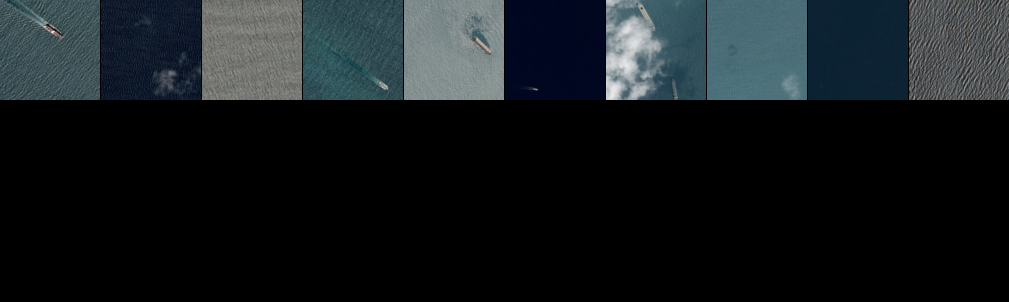

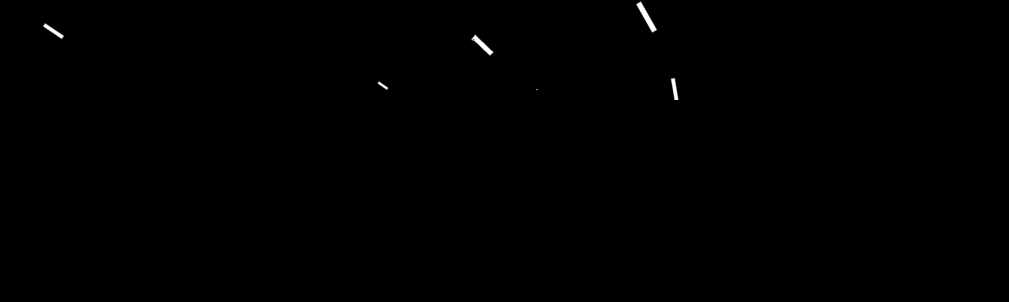

In [181]:
show_dataset_with_mask(100, 10, 3, test_gen)

In [207]:
K.clear_session()
# batch_size = 128
# log_dir = f"{os.environ['tb_path']}segmentation/incep_baseline_bs_{batch_size}_is_256_dl_aug/"
# if os.path.exists(log_dir) == False:
#     os.makedirs(log_dir)
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
# weights_path = f'/home/ubuntu/weights/segmentation/incep_baseline_bs_{batch_size}_is_256_dl_aug/'
# weights_save = CallbackForSavingModelWeights(weights_path)
# train_dataset = get_data(train, shape = (256, 256), batch_size=batch_size)
# val_dataset = get_data(val, test_=True, shape = (256, 256), batch_size=batch_size, shuffle=False, repeat=False)
batch_size = 128
with strategy.scope():
    model = get_model('inceptionv3')
    model_hist = model.fit(
        train_gen,
        steps_per_epoch = len(train) // (batch_size * REPLICAS),
        epochs = 1,
        verbose = 1,
        # validation_data = val_dataset,
        # callbacks = [tensorboard_callback, weights_save]
    )

1474/1474 [==============================] - 1894s 1s/step - loss: 0.6703 - iou_score: 0.2730


In [21]:
def read_train_imgs(img, mask, shape, condition):
    img = tf.io.read_file(img)
    mask = tf.io.read_file(mask)
    img = tf.image.decode_jpeg(img, channels=3)
    mask = tf.image.decode_jpeg(mask, channels=1)
    img = tf.cond(condition == 1, true_fn=lambda:tf.image.flip_left_right(img), false_fn = lambda : img)
    mask = tf.cond(condition == 1, true_fn=lambda:tf.image.flip_left_right(mask), false_fn = lambda : mask)
    img = tf.image.resize(img, size=shape)
    mask = tf.image.resize(mask, size=shape)
    img = img / 255
    mask = mask / 255
    return img, mask

def read_val_imgs(img, mask, shape):
    img = tf.io.read_file(img)
    mask = tf.io.read_file(mask)
    img = tf.image.decode_jpeg(img, channels=3)
    mask = tf.image.decode_jpeg(mask, channels=1)
    img = tf.image.resize(img, size=shape)
    mask = tf.image.resize(mask, size=shape)
    img = img / 255
    mask = mask / 255
    return img, mask


def apply_func(imgs, masks, shapes, conds):
    conds = tf.random.uniform(shape=(), minval=0, maxval=2, dtype=tf.int32)
    return imgs, masks, shapes, conds

def get_data(data, test_ = False, aug_seq = None, shape = (256, 256), shuffle = True, repeat = True, batch = True, batch_size = 32):
    imgs, masks = data['fixed_inputs'].values.tolist(), data['mask_paths'].values.tolist()
    shapes = [shape for x in range(len(imgs))]
    if test_ == False:
        conds = np.random.randint(0, 2, (len(train)))
        tensor = tf.data.Dataset.from_tensor_slices((imgs, masks, shapes, conds))
    else:
        tensor = tf.data.Dataset.from_tensor_slices((imgs, masks, shapes))
    tensor = tensor.cache()
    if repeat:
        tensor = tensor.repeat()
    if shuffle:
        tensor = tensor.shuffle(256 * REPLICAS)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        tensor = tensor.with_options(opt)
    if test_ == False:
        tensor = tensor.map(apply_func)
        tensor = tensor.map(read_train_imgs)
    else:
        tensor = tensor.map(read_val_imgs)
    if batch:
        tensor = tensor.batch(batch_size * REPLICAS)
    tensor = tensor.prefetch(AUTO)
    return tensor

In [22]:
train_dataset = get_data(train, shape = (256, 256), batch_size=64)
val_dataset = get_data(val, test_=True, shape = (256, 256), batch_size=64, shuffle=False, repeat=False)
test_dataset = get_data(test, test_=True, shape = (256, 256), batch_size=64, shuffle=False, repeat=False)

In [23]:
K.clear_session()
batch_size = 64
log_dir = f"{os.environ['tb_path']}segmentation/incep_baseline_bs_{batch_size}_is_256_dl_aug/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/weights/segmentation/incep_baseline_bs_{batch_size}_is_256_dl_aug/'
weights_save = CallbackForSavingModelWeights(weights_path)
train_dataset = get_data(train, shape = (256, 256), batch_size=batch_size)
val_dataset = get_data(val, test_=True, shape = (256, 256), batch_size=batch_size, shuffle=False, repeat=False)
with strategy.scope():
    model = get_model('inceptionv3')
    model_hist = model.fit(
        train_dataset,
        steps_per_epoch = len(train) // (batch_size * REPLICAS),
        epochs = 30,
        verbose = 1,
        validation_data = val_dataset,
        callbacks = [tensorboard_callback, weights_save]
    )

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [24]:
K.clear_session()
batch_size = 32
log_dir = f"{os.environ['tb_path']}segmentation/res101_baseline_bs_{batch_size}_is_256_dl_aug/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/weights/segmentation/res101_baseline_bs_{batch_size}_is_256_dl_aug/'
weights_save = CallbackForSavingModelWeights(weights_path)
train_dataset = get_data(train, shape = (256, 256), batch_size=batch_size)
val_dataset = get_data(val, test_=True, shape = (256, 256), batch_size=batch_size, shuffle=False, repeat=False)
with strategy.scope():
    model = get_model('resnet101')
    model_hist = model.fit(
        train_dataset,
        steps_per_epoch = len(train) // (batch_size * REPLICAS),
        epochs = 30,
        verbose = 1,
        validation_data = val_dataset,
        callbacks = [tensorboard_callback, weights_save]
    )

IndexError: list index out of range